In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import cv2

## Camera response function

In [2]:
m_list = [-1,0,1]

wvls_int = torch.linspace(400*1e-9, 675*1e-9, 12) # interpolation에 사용된 값
wvls = torch.linspace(400*1e-9, 680*1e-9, 29) # 400 ~ 780 까지 5nm 간격으로
wvls_nm = wvls*1e9
wvls_nm = wvls_nm.long()
wvls_nm # 400 ~ 780 까지 5nm 간격으로 integer

m_N = len(m_list)
wvls_N = len(wvls)

dat_path = './dat/'
if not os.path.exists(dat_path):
    os.makedirs(dat_path)

In [3]:
CRF_cam_int = torch.tensor([[0.0605, 0.0704, 0.2429], # 400nm
            [0.0309, 0.0506, 0.4154], # 425nm
            [0.0166, 0.0526, 0.5269], # 450nm quantum efficiency
            [0.0167, 0.1851, 0.5237], # 475nm quantum efficiency
            [0.0167, 0.5859, 0.3684], # 500nm quantum efficiency
            [0.0429, 0.6513,0.1623], # 525nm quantum efficiency
            [0.0250, 0.6301, 0.0642], # 550nm quantum efficiency
            [0.0708, 0.5533, 0.0218], # 575nm quantum efficiency
            [0.6073,0.3882,0.0169], # 600nm quantum efficiency
            [0.6058,0.1740,0.0137], # 625nm quantum efficiency
            [0.5453,0.1004,0.0268], # 650nm quantum efficiency
            [0.4145,0.0858,0.0351] # 675nm quantum efficiency
            # [0.0613,0.0237,0.0073], # 700nm quantum efficiency
            # [0.0021,0.0021,0.0021], # 725nm
            # [0.0009,0.0009,0.0009], # 750nm
            ]) 

In [4]:
from scipy import interpolate

def cubic_interpolation(x_new, x_points, y_points, n):
    tck = interpolate.splrep(x_points, y_points, k=n)   # Estimate the polynomial of nth degree by using x_points and y_points
    y_new = interpolate.splev(x_new, tck)
    return y_new

In [5]:
new_wvls = wvls
x_wvls = wvls_int

R_y_qe = CRF_cam_int[:,0] # R
R_y_new = cubic_interpolation(new_wvls, x_wvls, R_y_qe , 2)

G_y_qe = CRF_cam_int[:,1] # G
G_y_new = cubic_interpolation(new_wvls, x_wvls, G_y_qe , 2)

B_y_qe = CRF_cam_int[:,2] # B
B_y_new = cubic_interpolation(new_wvls, x_wvls, B_y_qe , 2)

In [6]:
R_y_qe

tensor([0.0605, 0.0309, 0.0166, 0.0167, 0.0167, 0.0429, 0.0250, 0.0708, 0.6073,
        0.6058, 0.5453, 0.4145])

In [7]:
CRF_cam = torch.zeros((wvls_N, 3))
R_y_new = torch.tensor(R_y_new)
G_y_new = torch.tensor(G_y_new)
B_y_new = torch.tensor(B_y_new)

CRF_cam[:,0] = R_y_new
CRF_cam[:,1] = G_y_new
CRF_cam[:,2] = B_y_new

In [9]:
# CRF_cam = np.load('./CRF_cam.npy')

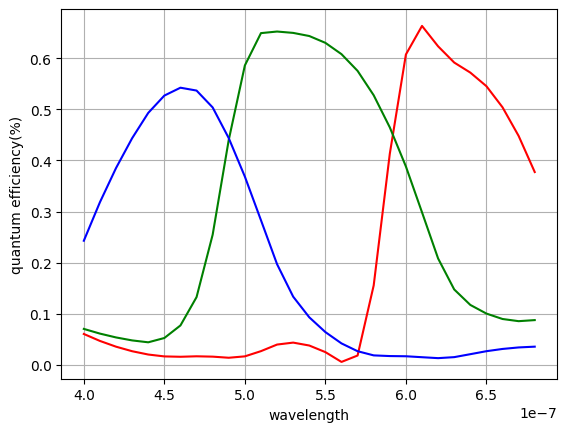

In [10]:
plt.plot(new_wvls, CRF_cam[:,0], color = 'red')
plt.plot(new_wvls, CRF_cam[:,1], color = 'green')
plt.plot(new_wvls, CRF_cam[:,2], color = 'blue')

plt.xlabel('wavelength')
plt.ylabel('quantum efficiency(%)')
plt.grid()
plt.show()

In [12]:
CRF_cam = np.save('./CRF_cam.npy', CRF_cam)

## Projector response function

In [13]:
# 이미지에서 읽어 들인 R의 값
# Camera의 특정 파장 lambda에서 R의 q.e
# 나머지 곱은 1

# rgb 이미지에 gamma correction한 p_r, p_g, p_b 값 / 각 img 100개씩
# 각 파장에 대한 r,g,b

#### gamma correction coefficients

In [20]:
rgb_fit = loadmat('C:/Users/owner/Documents/GitHub/Scalable-Hyperspectral-3D-Imaging/calibration/rgb_fit.mat')

In [21]:
rgb_fit = rgb_fit['p']

# fitting coefficients for rgb
r_a,r_b,r_c = rgb_fit[0,0],rgb_fit[0,1],rgb_fit[0,2]
g_a,g_b,g_c = rgb_fit[0,3],rgb_fit[0,4],rgb_fit[0,5]
b_a,b_b,b_c = rgb_fit[0,6],rgb_fit[0,7],rgb_fit[0,8]

#### bring rgb image patterns

In [22]:
rgb_random_value = np.load('./rgb_array.npy') # rgb_random pattern intensity

FileNotFoundError: [Errno 2] No such file or directory: './rgb_array.npy'

In [14]:
rgb = np.round(np.linspace(20,255,10))

In [15]:
rgb_val = np.zeros(shape=(10,3,3)) # num_img, rgb, rgb 채울 255,0,0 / 0,255,0 / 0,0,255

for i in range(len(rgb)):
    rgb_val[i,0,0] = rgb[i]
    rgb_val[i,1,1] = rgb[i]
    rgb_val[i,2,2] = rgb[i]

In [16]:
rgb_val[:,0,:] # 0 index : 각 rgb당 img 개수 / 1 index : 각 R_lambda, G_lambda, B_lambda / 2 index : 각 rgb intensity 값

array([[ 20.,   0.,   0.],
       [ 46.,   0.,   0.],
       [ 72.,   0.,   0.],
       [ 98.,   0.,   0.],
       [124.,   0.,   0.],
       [151.,   0.,   0.],
       [177.,   0.,   0.],
       [203.,   0.,   0.],
       [229.,   0.,   0.],
       [255.,   0.,   0.]])

In [17]:
# # bandpass filter의 wavelength
# # wvls_bandpass = torch.linspace(400, 700, 7) # for rgb random value
# # wvls_bandpass = wvls_bandpass.long()

# wvls_bandpass = torch.linspace(450, 700, 6) # for rgb
# wvls_bandpass = wvls_bandpass.long()

# # spectralon area
# roi = [917, 1017, 1100, 1200]
# # transmission
# T = 1
# # spectralon reflectance
# R = 1
# # number of random rgb patterns
# N_img = 10
# # projector gamma correction array
# proj_gam = np.zeros(shape=(N_img, 3))
# # I_r,I_g, I_b 합친 I
# I= np.zeros(shape=(len(wvls_bandpass), N_img,3))

# for w_i, wvls_lamb in enumerate(wvls_bandpass):
#     for i in range(3): # rgb
#         # camera CRF
#         idx = (wvls_nm == wvls_lamb).nonzero(as_tuple=False)[0][0] # 특정 lambda의 77채널 중 index 값
#         cam_CRF_value = CRF_cam[idx,i] # cam CRF 특정 lambda에 대한 rgb value

#         for j in range(N_img):
#             if i == 0:
#                 num = 20
#             elif i == 1:
#                 num = 10
#             else:
#                 num = 0
#             # captured image at specific wvls lambda
#             # img = cv2.imread('./experiments/rgb_random/%dnm/calibration0/rgb_pattern_%04d.png' %(wvls_lamb, j), -1).astype(np.float32)
#             img = cv2.imread('./experiments/rgb/%dnm/calibration0/rgb_pattern_%04d.png' %(wvls_lamb, num + j), -1).astype(np.float32)
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#             img /= 65535.0
#             img = img[roi[0]:roi[1], roi[2]:roi[3], :] # spectralon 영역
#             im_i_mean = img.mean(axis=(0,1)) # spectralon 영역 평균 rgb
#             intensity = im_i_mean[i] # C(RGB)_lambda
            
#             # rgb pattern before gamma correction
#             p_r, p_g, p_b = rgb_val[j, i, 0], rgb_val[j, i ,1], rgb_val[j, i, 2] # rgb pattern intensity
            
#             # after gamma correction 
#             p_r_gamma = r_a*(p_r**r_b)+r_c
#             p_g_gamma = g_a*(p_g**g_b)+g_c
#             p_b_gamma = b_a*(p_b**b_b)+b_c

#             # append projector gamma correction array for N_img 개의 rgb patterns
#             proj_gam[j,0],proj_gam[j,1], proj_gam[j,2] = p_r_gamma, p_g_gamma, p_b_gamma
        
#             # I_r, I_g, I_b
#             I[w_i, j, i] = intensity/(cam_CRF_value*R*T)

#### Only for R - debugging

In [18]:
# idx = (wvls_nm == 450).nonzero(as_tuple=False)[0][0] # wavelength 가 450 일때 wvls의 index 값
# cam_CRF_value_tmp = CRF_cam[idx,0]

In [19]:
wvls_bandpass = torch.linspace(400, 750, 8) # for rgb
wvls_bandpass = wvls_bandpass.long()

# transmission
T = 1
# spectralon reflectance
R = 1
# number of random rgb patterns
N_img = 10
# projector gamma correction array
proj_gam = np.zeros(shape=(N_img, 3))
# I_r,I_g, I_b 합친 I
I= np.zeros(shape=(len(wvls_bandpass), N_img,3))

roi = [917, 1017, 1100, 1200]
I_tmp = np.zeros(shape=(len(wvls_bandpass), N_img))
proj_gam_R = np.zeros(shape=(N_img, 3))

for w_i, wvls_lamb in enumerate(wvls_bandpass):
    # camera CRF
    idx = (wvls_nm == wvls_lamb).nonzero(as_tuple=False)[0][0] # 특정 lambda의 77채널 중 index 값
    cam_CRF_value = CRF_cam[idx,0] # cam CRF 특정 lambda에 대한 rgb value =======================================

    for i in range(N_img):
        img = cv2.imread('./experiments/rgb/%dnm/calibration0/rgb_pattern_%04d.png' %(wvls_lamb, 20+i), -1).astype(np.float32) # ==========================================
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img /= 65535.0
        img = img[roi[0]:roi[1], roi[2]:roi[3], :] # spectralon 영역
        im_i_mean = img.mean(axis=(0,1)) # 평균
        intensity = im_i_mean[0] # ==========================================

        p_r, p_g, p_b = rgb_val[i, 0, 0], rgb_val[i, 0 ,1], rgb_val[i, 0, 2] # ========================================== 1 index
        # after gamma correction 
        p_r_gamma = r_a*(p_r**r_b)+r_c
        p_g_gamma = g_a*(p_g**g_b)+g_c
        p_b_gamma = b_a*(p_b**b_b)+b_c

        proj_gam_R[i,0],proj_gam_R[i,1], proj_gam_R[i,2] = p_r_gamma, p_g_gamma, p_b_gamma

        I_tmp[w_i, i] = intensity/(cam_CRF_value*R*T)

In [20]:
rgb_num = 3 
CRF_proj_r = np.zeros(shape=(len(wvls_bandpass), 3))

for i in range(len(wvls_bandpass)):
    p = np.linalg.lstsq(proj_gam_R,I_tmp[i,:],rcond=None)[0]
    CRF_proj_r[i,:] = p

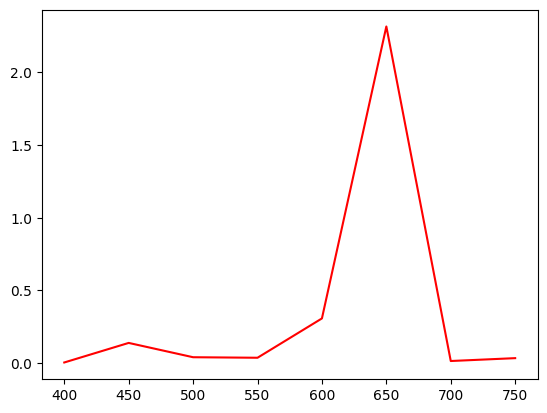

In [21]:
plt.plot(wvls_bandpass,CRF_proj_r[:,0], 'r')

#### Only for G - debugging

In [22]:
roi = [917, 1017, 1100, 1200]
I_tmp = np.zeros(shape=(len(wvls_bandpass), N_img))
proj_gam_G = np.zeros(shape=(N_img, 3))

for w_i, wvls_lamb in enumerate(wvls_bandpass):
    # camera CRF
    idx = (wvls_nm == wvls_lamb).nonzero(as_tuple=False)[0][0] # 특정 lambda의 77채널 중 index 값
    cam_CRF_value = CRF_cam[idx,1] # cam CRF 특정 lambda에 대한 rgb value =======================================

    for i in range(N_img):
        img = cv2.imread('./experiments/rgb/%dnm/calibration0/rgb_pattern_%04d.png' %(wvls_lamb, 10 +i), -1).astype(np.float32) # ==========================================
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img /= 65535.0
        img = img[roi[0]:roi[1], roi[2]:roi[3], :] # spectralon 영역
        im_i_mean = img.mean(axis=(0,1)) # 평균
        intensity = im_i_mean[1] # ==========================================

        p_r, p_g, p_b = rgb_val[i, 1, 0], rgb_val[i, 1 ,1], rgb_val[i, 1, 2] # ========================================== 1 index
        # after gamma correction 
        p_r_gamma = r_a*(p_r**r_b)+r_c
        p_g_gamma = g_a*(p_g**g_b)+g_c
        p_b_gamma = b_a*(p_b**b_b)+b_c

        proj_gam_G[i,0],proj_gam_G[i,1], proj_gam_G[i,2] = p_r_gamma, p_g_gamma, p_b_gamma

        I_tmp[w_i, i] = intensity/(cam_CRF_value*R*T)

In [23]:
rgb_num = 3 
CRF_proj_g = np.zeros(shape=(len(wvls_bandpass), 3))

for i in range(len(wvls_bandpass)):
    p = np.linalg.lstsq(proj_gam_G,I_tmp[i,:],rcond=None)[0]
    CRF_proj_g[i,:] = p

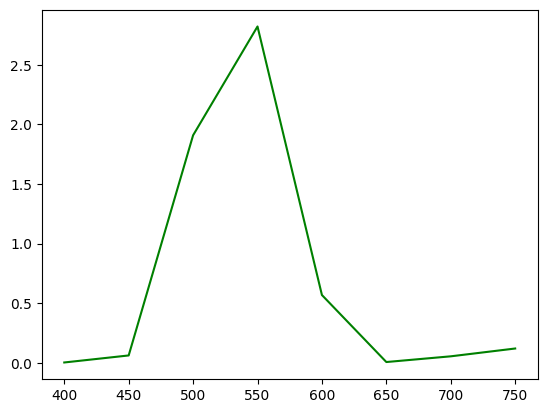

In [24]:
plt.plot(wvls_bandpass,CRF_proj_g[:,1], 'g')

#### Only for B - debugging

In [25]:
roi = [917, 1017, 1100, 1200]
I_tmp = np.zeros(shape=(len(wvls_bandpass), N_img))
proj_gam_B = np.zeros(shape=(N_img, 3))

for w_i, wvls_lamb in enumerate(wvls_bandpass):
    # camera CRF
    idx = (wvls_nm == wvls_lamb).nonzero(as_tuple=False)[0][0] # 특정 lambda의 77채널 중 index 값
    cam_CRF_value = CRF_cam[idx,2] # cam CRF 특정 lambda에 대한 rgb value =======================================

    for i in range(N_img):
        img = cv2.imread('./experiments/rgb/%dnm/calibration0/rgb_pattern_%04d.png' %(wvls_lamb, 0 +i), -1).astype(np.float32) # ==========================================
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img /= 65535.0
        img = img[roi[0]:roi[1], roi[2]:roi[3], :] # spectralon 영역
        im_i_mean = img.mean(axis=(0,1)) # 평균
        intensity = im_i_mean[2] # ==========================================

        p_r, p_g, p_b = rgb_val[i, 2, 0], rgb_val[i, 2 ,1], rgb_val[i, 2, 2] # ========================================== 1 index
        # after gamma correction 
        p_r_gamma = r_a*(p_r**r_b)+r_c
        p_g_gamma = g_a*(p_g**g_b)+g_c
        p_b_gamma = b_a*(p_b**b_b)+b_c

        proj_gam_B[i,0],proj_gam_B[i,1], proj_gam_B[i,2] = p_r_gamma, p_g_gamma, p_b_gamma

        I_tmp[w_i, i] = intensity/(cam_CRF_value*R*T)

In [26]:
wvls_bandpass

tensor([400, 450, 500, 550, 600, 650, 700, 750])

In [27]:
rgb_num = 3 
CRF_proj_b = np.zeros(shape=(len(wvls_bandpass), 3))

for i in range(len(wvls_bandpass)):
    p = np.linalg.lstsq(proj_gam_B,I_tmp[i,:],rcond=None)[0]
    CRF_proj_b[i,:] = p

In [28]:
print(CRF_proj_r[:,0].max())
print(CRF_proj_g[:,1].max())
print(CRF_proj_b[:,2].max())

2.3158219914719456
2.8217617170370546
2.3056619723706167


In [29]:
print(CRF_proj_r[:,0].min())
print(CRF_proj_g[:,1].min())
print(CRF_proj_b[:,2].min())

0.00471247321377416
0.0035607094522124958
0.0011970929001546863


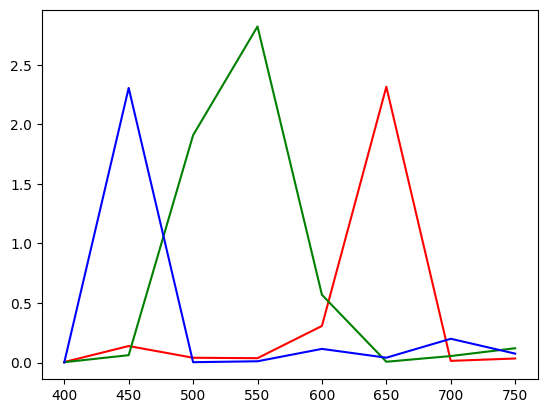

In [30]:
plt.plot(wvls_bandpass,CRF_proj_r[:,0], 'r')
plt.plot(wvls_bandpass,CRF_proj_g[:,1], 'g')
plt.plot(wvls_bandpass,CRF_proj_b[:,2], 'b')

In [31]:
# for j in range(3): # p의 rgb, index 2
#     for w_i, wvls_lamb in enumerate(wvls_bandpass):
#         weight_applyed = 0
#         idx = (wvls_nm == wvls_lamb).nonzero(as_tuple=False)[0][0] # 특정 lambda의 77채널 중 index 값
#         CRF_sum = np.sum(CRF_cam[idx]) # cam CRF 특정 lambda에 대한 rgb value 합

#         # camera CRF
#         idx = (wvls_nm == wvls_lamb).nonzero(as_tuple=False)[0][0] # 특정 lambda의 77채널 중 index 값
#         CRF_cam_value = CRF_cam[idx,0]/CRF_sum # cam CRF 특정 lambda에 대한 rgb value ==================================
#         CRF_proj_value = CRF_proj_r[w_i,j]
        
#         weight_applyed += CRF_cam_value * CRF_proj_value

#     CRF_proj_r[w_i,j] = weight_applyed

In [32]:
# for j in range(3): # p의 rgb, index 2
#     for w_i, wvls_lamb in enumerate(wvls_bandpass):
#         weight_applyed = 0
#         idx = (wvls_nm == wvls_lamb).nonzero(as_tuple=False)[0][0] # 특정 lambda의 77채널 중 index 값
#         CRF_sum = np.sum(CRF_cam[idx]) # cam CRF 특정 lambda에 대한 rgb value 합

#         # camera CRF
#         idx = (wvls_nm == wvls_lamb).nonzero(as_tuple=False)[0][0] # 특정 lambda의 77채널 중 index 값
#         CRF_cam_value = CRF_cam[idx,1]/CRF_sum # cam CRF 특정 lambda에 대한 rgb value ==================================
#         CRF_proj_value = CRF_proj_g[w_i,j]
        
#         weight_applyed += CRF_cam_value * CRF_proj_value

#     CRF_proj_g[w_i,j] = weight_applyed

In [33]:
# for j in range(3): # p의 rgb, index 2
#     for w_i, wvls_lamb in enumerate(wvls_bandpass):
#         weight_applyed = 0
#         idx = (wvls_nm == wvls_lamb).nonzero(as_tuple=False)[0][0] # 특정 lambda의 77채널 중 index 값
#         CRF_sum = np.sum(CRF_cam[idx]) # cam CRF 특정 lambda에 대한 rgb value 합

#         # camera CRF
#         idx = (wvls_nm == wvls_lamb).nonzero(as_tuple=False)[0][0] # 특정 lambda의 77채널 중 index 값
#         CRF_cam_value = CRF_cam[idx,2]/CRF_sum # cam CRF 특정 lambda에 대한 rgb value ==================================
#         CRF_proj_value = CRF_proj_b[w_i,j]
        
#         weight_applyed += CRF_cam_value * CRF_proj_value

#     CRF_proj_b[w_i,j] = weight_applyed

#### interpolation

#### Red insert

In [34]:
CRF_proj_r_ins = np.insert(CRF_proj_r[:,0], -1, (CRF_proj_r[:,0][-1] + CRF_proj_r[:,0][-2])/2) # 725 nm insert for Red
CRF_proj_r_ins = np.insert(CRF_proj_r_ins, 3, (CRF_proj_r[:,0][2] + CRF_proj_r[:,0][3])/2) # 525 nm insert for Red
CRF_proj_r_ins = np.insert(CRF_proj_r_ins, 1, (CRF_proj_r[:,0][0] + CRF_proj_r[:,0][1])/2) # 425 nm insert for Red
CRF_proj_r_ins = np.insert(CRF_proj_r_ins, -1, CRF_proj_r[:,0][-1]) # 780 nm insert for Red

#### Green insert

In [35]:
CRF_proj_g_ins = np.insert(CRF_proj_g[:,1], -1, (CRF_proj_g[:,1][-1] + CRF_proj_g[:,1][-2])/2) # 725 nm insert for Red
CRF_proj_g_ins = np.insert(CRF_proj_g_ins, 3, (CRF_proj_g[:,1][2] + CRF_proj_g[:,1][3])/2) # 525 nm insert for Red
CRF_proj_g_ins = np.insert(CRF_proj_g_ins, 1, (CRF_proj_g[:,1][0] + CRF_proj_g[:,1][1])/2) # 425 nm insert for Red
CRF_proj_g_ins = np.insert(CRF_proj_g_ins, -1, CRF_proj_g[:,1][-1]) # 425 nm insert for Red

#### Blue insert

In [36]:
CRF_proj_b_ins = np.insert(CRF_proj_b[:,2], -1, (CRF_proj_b[:,2][-1] + CRF_proj_b[:,2][-2])/2) # 725 nm insert for Red
CRF_proj_b_ins = np.insert(CRF_proj_b_ins, 3, (CRF_proj_b[:,2][2] + CRF_proj_b[:,2][3])/2) # 525 nm insert for Red
CRF_proj_b_ins = np.insert(CRF_proj_b_ins, 1, (CRF_proj_b[:,2][0] + CRF_proj_b[:,2][1])/2) # 425 nm insert for Red
CRF_proj_b_ins = np.insert(CRF_proj_b_ins, -1, CRF_proj_b[:,2][-1]) # 425 nm insert for Red

In [37]:
wvls_bandpass = wvls_bandpass.numpy()

In [38]:
wvls_bandpass_int = np.insert(wvls_bandpass, 1, 425)
wvls_bandpass_int = np.insert(wvls_bandpass_int, 4, 525)
wvls_bandpass_int = np.insert(wvls_bandpass_int, len(wvls_bandpass_int)-1, 725)
wvls_bandpass_int = np.insert(wvls_bandpass_int, len(wvls_bandpass_int), 780)

In [39]:
wvls_bandpass_int

array([400, 425, 450, 500, 525, 550, 600, 650, 700, 725, 750, 780],
      dtype=int64)

In [40]:
new_wvls = wvls
wvls_bandpass_nm = wvls_bandpass_int*1e-9

R_y_qe = CRF_proj_r_ins # R
R_y_new = cubic_interpolation(new_wvls, wvls_bandpass_nm, R_y_qe , 2)

G_y_qe = CRF_proj_g_ins # G
G_y_new = cubic_interpolation(new_wvls, wvls_bandpass_nm, G_y_qe , 2)

B_y_qe = CRF_proj_b_ins # B
B_y_new = cubic_interpolation(new_wvls, wvls_bandpass_nm, B_y_qe , 2)

In [41]:
CRF_proj_new = torch.zeros((wvls_N, 3))

R_y_new = torch.tensor(R_y_new)
G_y_new = torch.tensor(G_y_new)
B_y_new = torch.tensor(B_y_new)

CRF_proj_new[:,0] = R_y_new
CRF_proj_new[:,1] = G_y_new
CRF_proj_new[:,2] = B_y_new

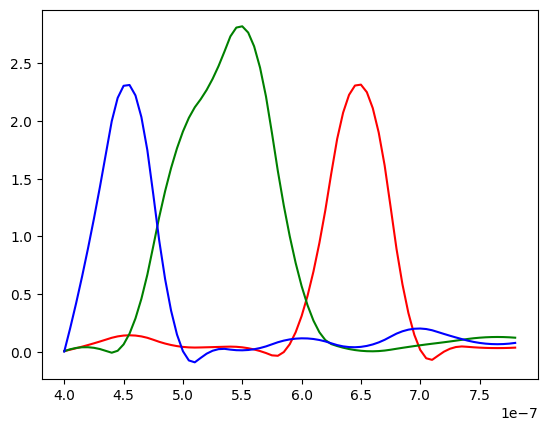

In [42]:
plt.plot(new_wvls, CRF_proj_new[:,0], color = 'red')
plt.plot(new_wvls, CRF_proj_new[:,1], color = 'green')
plt.plot(new_wvls, CRF_proj_new[:,2], color = 'b')

In [43]:
CRF_proj_new =np.clip(CRF_proj_new, 0, 3)

In [44]:
wvls_bandpass = wvls_bandpass*1e-9

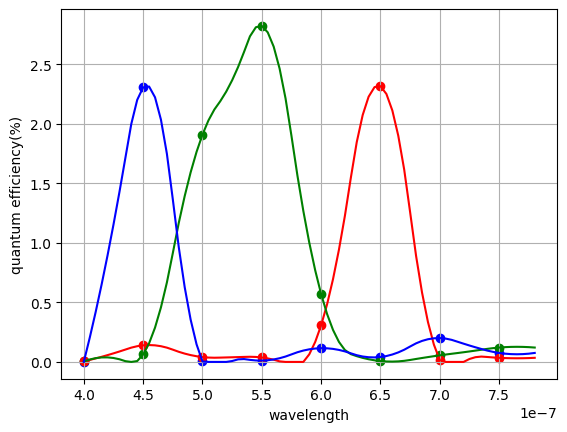

In [45]:
plt.plot(new_wvls, CRF_proj_new[:,0], color = 'red')
plt.plot(new_wvls, CRF_proj_new[:,1], color = 'green')
plt.plot(new_wvls, CRF_proj_new[:,2], color = 'b')
plt.grid()
plt.xlabel('wavelength')
plt.ylabel('quantum efficiency(%)')
plt.scatter(wvls_bandpass,CRF_proj_b[:,2], c='blue')
plt.scatter(wvls_bandpass,CRF_proj_g[:,1], c='green')
plt.scatter(wvls_bandpass,CRF_proj_r[:,0], c='red')
plt.savefig('./CRF_proj.svg')

In [46]:
np.save('./CRF_proj.npy', CRF_proj_new)

In [47]:
# rgb_num = 3 
# CRF_proj_rgb = np.zeros(shape=(rgb_num, len(wvls_bandpass), 3))

# for i in range(len(wvls_bandpass)):
#     for j in range(3):
#         p = np.linalg.lstsq(proj_gam,I[i,:,j],rcond=None)[0]
#         CRF_proj_rgb[j,i,:] = p

In [48]:
# # CRF_proj_rgb[r/g/b, 7, 3 결과 p]
# CRF_proj = np.zeros(shape=(rgb_num, len(wvls_bandpass)))

In [49]:
# for j in range(3): # p의 rgb, index 2
#     for w_i, wvls_lamb in enumerate(wvls_bandpass):
#         weight_applyed = 0
#         idx = (wvls_nm == wvls_lamb).nonzero(as_tuple=False)[0][0] # 특정 lambda의 77채널 중 index 값
#         CRF_sum = np.sum(CRF_cam[idx]) # cam CRF 특정 lambda에 대한 rgb value 합
        
#         for i in range(3): # I의 rgb, index 0
#             # camera CRF
#             idx = (wvls_nm == wvls_lamb).nonzero(as_tuple=False)[0][0] # 특정 lambda의 77채널 중 index 값
#             CRF_cam_value = CRF_cam[idx,i]/CRF_sum # cam CRF 특정 lambda에 대한 rgb value
#             CRF_proj_value = CRF_proj_rgb[i,w_i,j]
            
#             weight_applyed += CRF_cam_value * CRF_proj_value

#         CRF_proj[j, w_i] = weight_applyed